In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install --upgrade pip setuptools wheel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 74.0 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


In [1]:
%cd '/content/drive/MyDrive/guided_grounded_instructpix2pix/'

/content/drive/MyDrive/guided_grounded_instructpix2pix


In [2]:
!pip install groundingdino-py

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for groundingdino-py: filename=groundingdino_py-0.4.0-py2.py3-none-any.whl size=88812 sha256=7a051819b36314a7281788f4bc191e743ba4965a4f70575c38c6ea3234cd0b3f
  Stored in directory: /root/.cache/pip/wheels/74/c4/d6/2c6ded61819d391715b4f1ae483f2cfdc8f2eeb6bbb63e748b
Successfully built groundingdino-py
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [groundingdino-py]


In [3]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 27.6 MB/s  0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
!pip install diffusers transformers accelerate scipy safetensors

In [5]:
!pip install segment-anything

In [6]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 12.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [torchmetrics]


In [7]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-swjsdd6a
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-swjsdd6a
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369549 sha256=cb4f2cd2868eb6329d5d233d3432e27ea78284a3f7322d20e852b0cfb2f05d3a
  Stored in directory: /tmp/pip-ephem-wheel-cache-8f5pikxl/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [clip]


In [8]:
!pip install transformers torch peft tqdm numpy scikit-learn

In [9]:
import math
import torch
import os
from PIL import Image
from pathlib import Path

from tqdm.notebook import tqdm
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

from diffusers import DDIMScheduler, DDIMInverseScheduler
from pipeline_stable_diffusion_grounded_instruct_pix2pix import StableDiffusionInstructPix2PixPipeline

from external_mask_extractor_improved import ExternalMaskExtractor
from transformers import logging

import pandas as pd
import re

logging.set_verbosity_error()

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [10]:
def load_pil_image_no_pad(path, max_res=512):
    img = Image.open(path).convert("RGB")
    orig_w, orig_h = img.size
    # Keep original aspect ratio, but limit longest side to max_res
    scale = max_res / max(orig_w, orig_h)
    new_w = int((orig_w * scale) // 8) * 8
    new_h = int((orig_h * scale) // 8) * 8
    resized = img.resize((new_w, new_h), Image.Resampling.LANCZOS)
    return resized, (orig_w, orig_h)

def restore_original_resolution(edited_img, original_size):
    return edited_img.resize(original_size, Image.Resampling.LANCZOS)

In [11]:
device = 'cuda:0'

# pipeline
num_timesteps = 100
pipeline = StableDiffusionInstructPix2PixPipeline.from_pretrained("timbrooks/instruct-pix2pix",
                                                                  torch_dtype=torch.float16,
                                                                  safety_checker=None).to(device)
pipeline.inverse_scheduler = DDIMInverseScheduler.from_config(pipeline.scheduler.config, set_alpha_to_zero=False)

pipeline.scheduler.set_timesteps(num_timesteps)
pipeline.inverse_scheduler.set_timesteps(num_timesteps)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/diffusers/loaders/lora_pipeline.py:5501: FutureWarning: `LoraLoaderMixin` is deprecated and will be removed in version 1.0.0. LoraLoaderMixin is deprecated and this will be removed in a future version. Please use `StableDiffusionLoraLoaderMixin`, instead.
  deprecate("LoraLoaderMixin", "1.0.0", deprecation_message)
The config attributes {'algorithm_type': 'dpmsolver++', 'dynamic_thresholding_ratio': 0.995, 'lower_order_final': True, 'sample_max_value': 1.0, 'skip_prk_steps': True, 'solver_order': 2, 'solver_type': 'midpoint', 'thresholding': False} were passed to DDIMInverseScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.
/usr/local/lib/python3.12/dist-packages/diffusers/schedulers/scheduling_ddim_inverse.py:198: FutureWarning: The `set_alpha_to_zero` argument is deprecated. Please use `set_alpha_to_one` instead.
  deprecate("set_alpha_to_zero", "1.0.0", deprecation_message, standar

In [12]:
torch.cuda.empty_cache()
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Define model paths here
SAM_PATH = '/content/drive/MyDrive/SAM/sam_vit_h_4b8939.pth'
TARGET_PREDICTOR_PATH = "/content/drive/MyDrive/guided_grounded_instructpix2pix/models/target_finder_bert_lora_model/"
SIZE_PREDICTOR_PATHS = ["/content/drive/MyDrive/guided_grounded_instructpix2pix/models/size_predictor_models/standardSmoothL1_model.pth",
                        "/content/drive/MyDrive/guided_grounded_instructpix2pix/models/size_predictor_models/CombLoss_model.pth"]

device = 'cuda:0'
extractor = ExternalMaskExtractor(
    device=device,
    target_predictor_model_path=TARGET_PREDICTOR_PATH,
    size_predictor_model_path=SIZE_PREDICTOR_PATHS,
    sam_path=SAM_PATH
)

def inference(pipeline, image_pil, instruction, image_guidance_scale, text_guidance_scale, seed, blending_range):
    final_mask, first_target_phrase, second_target_phrase, directional_phrase, final_sentence, predicted_size_mask = extractor.get_external_mask(image_pil, instruction, verbose=True)

    inv_results = pipeline.invert(final_sentence, image_pil, num_inference_steps=num_timesteps, inv_range=blending_range)
    generator = torch.Generator(device).manual_seed(seed) if seed is not None else torch.Generator(device)
    edited_image = pipeline(final_sentence, src_mask=final_mask, image=image_pil,
                            guidance_scale=text_guidance_scale, image_guidance_scale=image_guidance_scale,
                            num_inference_steps=num_timesteps, generator=generator).images[0]
    return edited_image, final_mask, predicted_size_mask

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Loading CLIP model...


100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 63.0MiB/s]


Loading size prediction models...
  > Loading model from: /content/drive/MyDrive/guided_grounded_instructpix2pix/models/size_predictor_models/standardSmoothL1_model.pth
  > Loading model from: /content/drive/MyDrive/guided_grounded_instructpix2pix/models/size_predictor_models/CombLoss_model.pth
All models loaded successfully.


GroundingDINO_SwinB.cfg.py: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

groundingdino_swinb_cogcoor.pth:   0%|          | 0.00/938M [00:00<?, ?B/s]

# **##################################**
For single image edit:
"If you want to edit a single image using a prompt, run the following code:"

Prompt convert the stone on the left of the bird to autumn leaves
First Target: bird
First Target Phrase: the bird
Second Target: stone
Second Target Phrase: the stone
Directional Word: left
Directional Phrase: on the left of
Final Sentence: convert the stone to autumn leaves
Matched direction: left
Direction_is_used:  False


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/groundingdino/models/GroundingDINO/transformer.py:862: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprec

Shape of Boxes for the bird  :  torch.Size([1, 4])
Shape of Boxes for bird  (without the) :  torch.Size([1, 4])
ALL Boxes xyxy1 Shape:  torch.Size([2, 4])
bird  is_singular? -->  True
Filtered Boxes1 Shape:  torch.Size([1, 4])
boxes_xyxy1:  tensor([[259.6685,  93.8895, 307.1595, 165.8392]])
Shape of Boxes for the stone  :  torch.Size([1, 4])
Shape of Boxes for stone  (without the) :  torch.Size([10, 4])
ALL Boxes xyxy1 Shape:  torch.Size([11, 4])
stone  is_singular? -->  True
Filtered Boxes2 Shape:  torch.Size([9, 4])
Direction_is_used?  False
Apply_relative_directional_logic left
Directed Filtered Boxes2 Shape:  torch.Size([1, 4]) Direction_is_used?  True
boxes_xyxy2:  tensor([[141.2099, 123.9654, 262.9326, 156.5044]])


  0%|          | 0/100 [00:00<?, ?it/s]

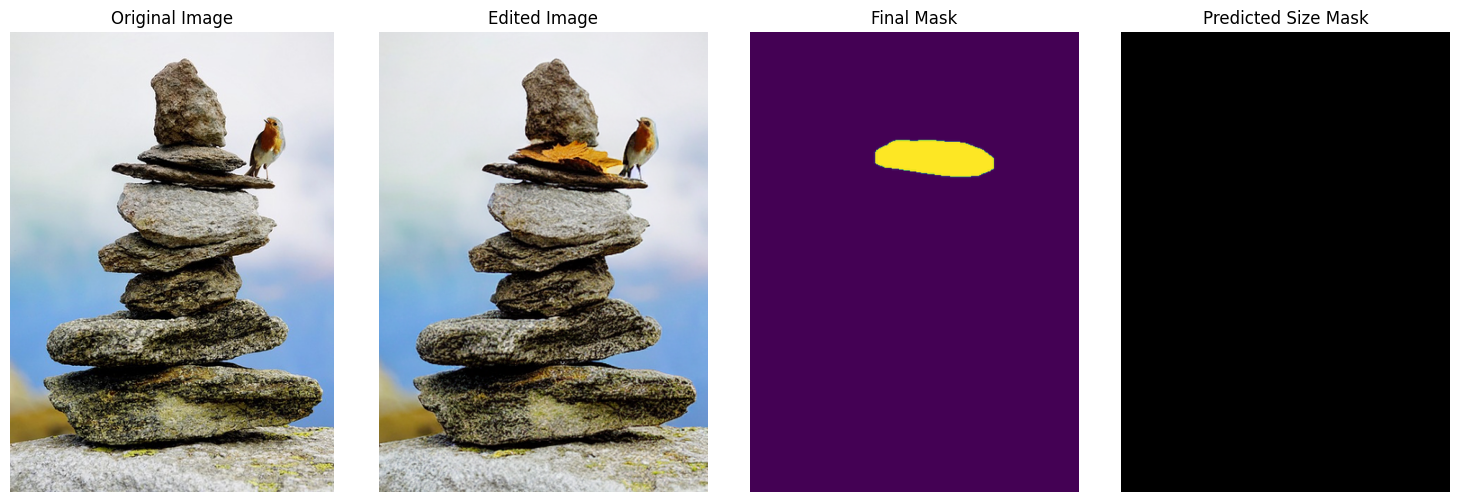

In [16]:
def edit_image(
    pipeline,
    image_path,
    edit_instruction,
    image_guidance_scale=1.5,
    guidance_scale=7.5,
    seed=42,
    start_blending_at_tstep=100,
    end_blending_at_tstep=1,
    verbose=False
):
    blending_range = [start_blending_at_tstep, end_blending_at_tstep]

    image_resized, original_size = load_pil_image_no_pad(image_path)
    edited_image, final_mask, predicted_size_mask = inference(
        pipeline, image_resized, edit_instruction,
        image_guidance_scale=image_guidance_scale,
        text_guidance_scale=guidance_scale,
        seed=seed,
        blending_range=blending_range
    )

##############################################################
    # Extract original image filename without extension
    original_filename = Path(image_path).stem

    # Define output directories
    edited_dir = Path('/content/drive/MyDrive/guided_grounded_instructpix2pix/output/ggip2p_edited_images')
    mask_dir = Path('/content/drive/MyDrive/guided_grounded_instructpix2pix/output/ggip2p_edited_masks')

    # Create directories if they don't exist
    edited_dir.mkdir(parents=True, exist_ok=True)
    mask_dir.mkdir(parents=True, exist_ok=True)

    # Convert mask to PIL Images if needed
    if not isinstance(final_mask, Image.Image):
        final_mask = Image.fromarray(final_mask.astype('uint8'))
    # Handle predicted_size_mask safely
    if predicted_size_mask is not None:
        if torch.is_tensor(predicted_size_mask):
            predicted_size_mask = Image.fromarray((predicted_size_mask.cpu().numpy() * 255).astype('uint8'))
    else:
        predicted_size_mask = Image.new('L', image_resized.size, 128)  # dummy gray image, or skip plotting it

    # Create path and name with instruction + original_filename
    edited_image_path = edited_dir / f'{original_filename}.jpg'
    final_mask_path = mask_dir / f'{original_filename}.png'
    predicted_size_mask_path = mask_dir / f'{original_filename}_primary_mask.png'

    # Restore size
    edited_image = restore_original_resolution(edited_image, original_size)
    final_mask = restore_original_resolution(final_mask, original_size)
    predicted_size_mask = restore_original_resolution(predicted_size_mask, original_size)

    # Save
    edited_image.save(edited_image_path)
    final_mask.save(final_mask_path)
    predicted_size_mask.save(predicted_size_mask_path)
##############################################################

    fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    axes[0].imshow(image_resized)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(edited_image)
    axes[1].set_title('Edited Image')
    axes[1].axis('off')

    axes[2].imshow(final_mask)
    axes[2].set_title('Final Mask')
    axes[2].axis('off')

    axes[3].imshow(predicted_size_mask, cmap='gray')
    axes[3].set_title('Predicted Size Mask')
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

edit_image(
    pipeline=pipeline,
    image_path = '/content/drive/MyDrive/imgs/cairn-2806850_640-pixabay.com.jpg',
    edit_instruction = 'convert the stone on the left of the bird to autumn leaves',
    image_guidance_scale=1.5,
    guidance_scale=7.5,
    seed=42,
    start_blending_at_tstep = 100
)

# **##################################**
For the full test set:  
"If you want to edit the entire test set of images using their corresponding prompt pairs from an Excel file, run the following code:"

In [ ]:
verbose = False

def edit_image(
    pipeline,
    image_path,
    edit_instruction,
    image_guidance_scale=1.5,
    guidance_scale=7.5,
    seed=42,
    start_blending_at_tstep=100,
    end_blending_at_tstep=1,
    verbose=False
):
    blending_range = [start_blending_at_tstep, end_blending_at_tstep]

    image_resized, original_size = load_pil_image_no_pad(image_path)
    edited_image, final_mask, predicted_size_mask = inference(
        pipeline, image_resized, edit_instruction,
        image_guidance_scale=image_guidance_scale,
        text_guidance_scale=guidance_scale,
        seed=seed,
        blending_range=blending_range
    )

##############################################################
    # Extract original image filename without extension
    original_filename = Path(image_path).stem

    # Sanitize edit_instruction for filename (replace spaces and special chars with _)
    safe_instruction = re.sub(r'[^a-zA-Z0-9]+', '_', edit_instruction.strip()).strip('_')

    # Define output directories
    edited_dir = Path('/content/drive/MyDrive/guided_grounded_instructpix2pix/output/ggip2p_edited_images')
    mask_dir = Path('/content/drive/MyDrive/guided_grounded_instructpix2pix/output/ggip2p_edited_masks')

    # Create directories if they don't exist
    edited_dir.mkdir(parents=True, exist_ok=True)
    mask_dir.mkdir(parents=True, exist_ok=True)

    # Convert masks to PIL Images if needed
    if not isinstance(final_mask, Image.Image):
        final_mask = Image.fromarray(final_mask.astype('uint8'))
    # Handle predicted_size_mask safely
    if predicted_size_mask is not None:
        if torch.is_tensor(predicted_size_mask):
            predicted_size_mask = Image.fromarray((predicted_size_mask.cpu().numpy() * 255).astype('uint8'))
    else:
        predicted_size_mask = Image.new('L', image_resized.size, 128)  # dummy gray image, or skip plotting it

    # Create paths and names with instruction + original_filename
    edited_image_path = edited_dir / f'{original_filename}_{safe_instruction}.jpg'
    final_mask_path = mask_dir / f'{original_filename}_{safe_instruction}.png'
    predicted_size_mask_path = mask_dir / f'{original_filename}_{safe_instruction}_primary_mask.png'

    # Restore sizes
    edited_image = restore_original_resolution(edited_image, original_size)
    final_mask = restore_original_resolution(final_mask, original_size)
    predicted_size_mask = restore_original_resolution(predicted_size_mask, original_size)

    # Save
    edited_image.save(edited_image_path)
    final_mask.save(final_mask_path)
    # predicted_size_mask.save(predicted_size_mask_path)
##############################################################

excel_path = "/content/drive/MyDrive/All_RESULTS/All_img_instruct_info.xlsx"
df = pd.read_excel(excel_path)
images_dir = "/content/drive/MyDrive/imgs/"

for index, row in df.iterrows():
    image_name = row['image_name']
    edit_instruction = row['instruct']
    image_path = str(Path(images_dir) / image_name)

    edit_image(
        pipeline=pipeline,
        image_path=image_path,
        edit_instruction=edit_instruction,
        image_guidance_scale=1.5,
        guidance_scale=7.5,
        seed=42,
        start_blending_at_tstep=100,
        verbose=verbose
    )

Prompt Add sunset to the bottom
First Target: No target found
First Target Phrase: 
Second Target: No second target found
Second Target Phrase: 
Directional Word: bottom
Directional Phrase: to the bottom
Final Sentence: Add sunset
No valid targets detected, falling back to full image mask.
direction_word bottom


  0%|          | 0/100 [00:00<?, ?it/s]

Prompt Add sunset to the top
First Target: No target found
First Target Phrase: 
Second Target: No second target found
Second Target Phrase: 
Directional Word: top
Directional Phrase: to the top
Final Sentence: Add sunset
No valid targets detected, falling back to full image mask.
direction_word top


  0%|          | 0/100 [00:00<?, ?it/s]

Prompt change the cat on the left to a tiger
First Target: cat
First Target Phrase: the cat
Second Target: No second target found
Second Target Phrase: 
Directional Word: left
Directional Phrase: on the left
Final Sentence: change to a tiger
Matched direction: left
Direction_is_used:  False


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/groundingdino/models/GroundingDINO/transformer.py:862: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprec

Shape of Boxes for the cat  :  torch.Size([1, 4])
Shape of Boxes for cat  (without the) :  torch.Size([1, 4])
ALL Boxes xyxy1 Shape:  torch.Size([2, 4])
cat  is_singular? -->  True
Filtered Boxes1 Shape:  torch.Size([2, 4])
apply_directional_logic left
Directed Filtered Boxes1 Shape:  torch.Size([1, 4]) Direction_is_used?  True
boxes_xyxy1:  tensor([[-2.6756e-02,  5.6396e+01,  1.7116e+02,  3.4425e+02]])
Not using size predictor - no direction or direction already used.


  0%|          | 0/100 [00:00<?, ?it/s]

Prompt change the cat on the right to a tiger
First Target: cat
First Target Phrase: the cat
Second Target: No second target found
Second Target Phrase: 
Directional Word: right
Directional Phrase: on the right
Final Sentence: change to a tiger
Matched direction: right
Direction_is_used:  False


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/groundingdino/models/GroundingDINO/transformer.py:862: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprec

Shape of Boxes for the cat  :  torch.Size([1, 4])
Shape of Boxes for cat  (without the) :  torch.Size([1, 4])
ALL Boxes xyxy1 Shape:  torch.Size([2, 4])
cat  is_singular? -->  True
Filtered Boxes1 Shape:  torch.Size([2, 4])
apply_directional_logic right
Directed Filtered Boxes1 Shape:  torch.Size([1, 4]) Direction_is_used?  True
boxes_xyxy1:  tensor([[347.3539,  19.2637, 512.0341, 343.0306]])
Not using size predictor - no direction or direction already used.


  0%|          | 0/100 [00:00<?, ?it/s]

Prompt Turn the frame above the vase into a colorful portrait
First Target: vase
First Target Phrase: the vase
Second Target: frame
Second Target Phrase: the frame
Directional Word: above
Directional Phrase: the above
Final Sentence: Turn the frame above into a colorful portrait
Matched direction: top
Direction_is_used:  False


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/groundingdino/models/GroundingDINO/transformer.py:862: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprec

Shape of Boxes for the vase  :  torch.Size([2, 4])
Shape of Boxes for vase  (without the) :  torch.Size([2, 4])
ALL Boxes xyxy1 Shape:  torch.Size([4, 4])
vase  is_singular? -->  True
Filtered Boxes1 Shape:  torch.Size([1, 4])
boxes_xyxy1:  tensor([[236.6890, 311.8167, 269.2002, 375.5955]])
Shape of Boxes for the frame  :  torch.Size([2, 4])
Shape of Boxes for frame  (without the) :  torch.Size([1, 4])
ALL Boxes xyxy1 Shape:  torch.Size([3, 4])
frame  is_singular? -->  True
Filtered Boxes2 Shape:  torch.Size([3, 4])
Direction_is_used?  False
Apply_relative_directional_logic top
Directed Filtered Boxes2 Shape:  torch.Size([1, 4]) Direction_is_used?  True
boxes_xyxy2:  tensor([[189.1377,  93.5928, 284.0639, 188.7015]])


  0%|          | 0/100 [00:00<?, ?it/s]

Prompt Turn the books stack on the right of the flower vase into a cake
First Target: vase
First Target Phrase: the flower vase
Second Target: books stack
Second Target Phrase: the books
Directional Word: right
Directional Phrase: on the right of
Final Sentence: Turn the books stack into a cake
Matched direction: right
Direction_is_used:  False


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/groundingdino/models/GroundingDINO/transformer.py:862: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprec

Shape of Boxes for the flower vase  :  torch.Size([2, 4])
Shape of Boxes for flower vase  (without the) :  torch.Size([2, 4])
ALL Boxes xyxy1 Shape:  torch.Size([4, 4])
vase  is_singular? -->  True
Filtered Boxes1 Shape:  torch.Size([1, 4])
boxes_xyxy1:  tensor([[238.4435,  52.3141, 278.6474,  94.5208]])
Shape of Boxes for the books  :  torch.Size([1, 4])
Shape of Boxes for books  (without the) :  torch.Size([2, 4])
ALL Boxes xyxy1 Shape:  torch.Size([3, 4])
books stack  is_singular? -->  True
Filtered Boxes2 Shape:  torch.Size([2, 4])
Direction_is_used?  False
Apply_relative_directional_logic right
Directed Filtered Boxes2 Shape:  torch.Size([1, 4]) Direction_is_used?  True
boxes_xyxy2:  tensor([[282.0068,  61.0803, 336.0364,  87.9214]])


  0%|          | 0/100 [00:00<?, ?it/s]

Prompt Change the chair on the right of the table to a black leather chair
First Target: table
First Target Phrase: the table
Second Target: chair
Second Target Phrase: the chair
Directional Word: right
Directional Phrase: on the right of
Final Sentence: Change the chair to a black leather chair
Matched direction: right
Direction_is_used:  False


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/groundingdino/models/GroundingDINO/transformer.py:862: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprec

Shape of Boxes for the table  :  torch.Size([1, 4])
Shape of Boxes for table  (without the) :  torch.Size([1, 4])
ALL Boxes xyxy1 Shape:  torch.Size([2, 4])
table  is_singular? -->  True
Filtered Boxes1 Shape:  torch.Size([1, 4])
boxes_xyxy1:  tensor([[ 37.6864, 302.5231, 162.4181, 443.7518]])
Shape of Boxes for the chair  :  torch.Size([1, 4])
Shape of Boxes for chair  (without the) :  torch.Size([2, 4])
ALL Boxes xyxy1 Shape:  torch.Size([3, 4])
chair  is_singular? -->  True
Filtered Boxes2 Shape:  torch.Size([2, 4])
Direction_is_used?  False
Apply_relative_directional_logic right
Directed Filtered Boxes2 Shape:  torch.Size([1, 4]) Direction_is_used?  True
boxes_xyxy2:  tensor([[136.6311, 305.6262, 218.8115, 422.7682]])


  0%|          | 0/100 [00:00<?, ?it/s]

Prompt Change the green vase to a white vase
First Target: vase
First Target Phrase: the green vase
Second Target: No second target found
Second Target Phrase: 
Directional Word: 
Directional Phrase: 
Final Sentence: Change to a white vase


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/groundingdino/models/GroundingDINO/transformer.py:862: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprec

Shape of Boxes for the green vase  :  torch.Size([2, 4])
Shape of Boxes for green vase  (without the) :  torch.Size([1, 4])
ALL Boxes xyxy1 Shape:  torch.Size([3, 4])
vase  is_singular? -->  True
Filtered Boxes1 Shape:  torch.Size([1, 4])
boxes_xyxy1:  tensor([[ 84.5797, 283.1668, 109.9423, 311.1448]])
Not using size predictor - no direction or direction already used.


  0%|          | 0/100 [00:00<?, ?it/s]

Prompt Change the pastry on the left to a donut
First Target: pastry
First Target Phrase: the pastry
Second Target: No second target found
Second Target Phrase: 
Directional Word: left
Directional Phrase: on the left
Final Sentence: Change to a donut
Matched direction: left
Direction_is_used:  False


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/groundingdino/models/GroundingDINO/transformer.py:862: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprec

Shape of Boxes for the pastry  :  torch.Size([1, 4])
Shape of Boxes for pastry  (without the) :  torch.Size([2, 4])
ALL Boxes xyxy1 Shape:  torch.Size([3, 4])
pastry  is_singular? -->  True
Filtered Boxes1 Shape:  torch.Size([2, 4])
apply_directional_logic left
Directed Filtered Boxes1 Shape:  torch.Size([1, 4]) Direction_is_used?  True
boxes_xyxy1:  tensor([[ 60.5955, 351.9492, 103.9743, 386.3477]])
Not using size predictor - no direction or direction already used.


  0%|          | 0/100 [00:00<?, ?it/s]

Prompt Convert the pumpkin on the top into a watermelon
First Target: pumpkin
First Target Phrase: the pumpkin
Second Target: No second target found
Second Target Phrase: 
Directional Word: top
Directional Phrase: on the top
Final Sentence: Convert into a watermelon
Matched direction: top
Direction_is_used:  False


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/groundingdino/models/GroundingDINO/transformer.py:862: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprec

Shape of Boxes for the pumpkin  :  torch.Size([1, 4])
Shape of Boxes for pumpkin  (without the) :  torch.Size([3, 4])
ALL Boxes xyxy1 Shape:  torch.Size([4, 4])
pumpkin  is_singular? -->  True
Filtered Boxes1 Shape:  torch.Size([3, 4])
apply_directional_logic top
Directed Filtered Boxes1 Shape:  torch.Size([1, 4]) Direction_is_used?  True
boxes_xyxy1:  tensor([[232.3303, 117.5033, 288.4007, 170.0549]])
Not using size predictor - no direction or direction already used.


  0%|          | 0/100 [00:00<?, ?it/s]

Replaced 'him' with 'man'
Prompt make him red hair
First Target: man
First Target Phrase: man
Second Target: No second target found
Second Target Phrase: 
Directional Word: 
Directional Phrase: 
Final Sentence: make red hair


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/groundingdino/models/GroundingDINO/transformer.py:862: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprec

Shape of Boxes for man  :  torch.Size([1, 4])
ALL Boxes xyxy1 Shape:  torch.Size([1, 4])
man  is_singular? -->  True
boxes_xyxy1:  tensor([[8.1125e-02, 1.6195e+02, 1.0304e+02, 4.3680e+02]])
Not using size predictor - no direction or direction already used.
